# Dealing With Imbalanced Classes: SMOTE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import timeit

%matplotlib inline

In [2]:
df = pd.read_excel('../data/default of credit card clients.xls') 
df = df.iloc[1:, 1:]
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
X = df.loc[:,'X1':'X23']
y = df.loc[:, 'Y'].astype('category')

## Split the data into training and test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=.25,
                                                 random_state=42)

In [5]:
from collections import Counter
Counter(y_train).items()

dict_items([(0, 17491), (1, 5009)])

In [6]:
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE().fit_sample(X_train, y_train)
Counter(y_train).items()

dict_items([(0, 17491), (1, 17491)])

# Decision Tree

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#params = {'max_depth':range(1,30)}
#gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=10)
#gscv.fit(X_train,y_train)
#print(gscv.best_params_)

In [8]:
#best param output:{'max_depth': 10}

In [9]:
start = timeit.default_timer()

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train,y_train)

stop = timeit.default_timer()

print(f'training accuracy: {dtc.score(X_train,y_train):0.4f}')
print(f'test accuracy: {dtc.score(X_test,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, dtc.predict(X_test)):0.4f}')
print('Time: ', round(stop - start, 4), 's')

training accuracy: 0.8679
test accuracy: 0.8101
AUC: 0.6577
Time:  0.3745 s


# Gradient Boosting without Feature Selection

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

#params = {'learning_rate':[0.1,0.05,0.01],
#          'n_estimators':[10,50,100],
#          'max_depth':[1,2,5,7],
#          'min_samples_split': [2,3,4],
#          'min_samples_leaf':[1,3,5]}
#gscv = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1)
#gscv.fit(X_train,y_train)
#print(gscv.best_params_)

In [11]:
# best params output{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 100}

In [12]:
start = timeit.default_timer()

gbc = GradientBoostingClassifier(learning_rate=0.1,
                                 max_depth=7,
                                 min_samples_leaf=3,
                                 min_samples_split=4,
                                 n_estimators=100,
                                 )
gbc.fit(X_train,y_train)

stop = timeit.default_timer()

print(f'training accuracy: {gbc.score(X_train,y_train):0.4f}')
print(f'test accuracy: {gbc.score(X_test,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, gbc.predict(X_test)):0.4f}')
print('Time: ', round(stop - start, 4), 's')

training accuracy: 0.9052
test accuracy: 0.8187
AUC: 0.6623
Time:  27.0777 s


# Gradient Boosting with Feature Selection

X6     0.4158
X4     0.1239
X2     0.0735
X3     0.0632
X12    0.0519
X7     0.0367
X8     0.0307
X9     0.0279
X21    0.0185
X1     0.0184
X19    0.0173
X11    0.0172
X18    0.0163
X10    0.0136
X5     0.0121
X20    0.0091
X13    0.0088
X23    0.0084
X14    0.0081
X17    0.0081
X15    0.0074
X22    0.0068
X16    0.0063
dtype: float64

<AxesSubplot:>

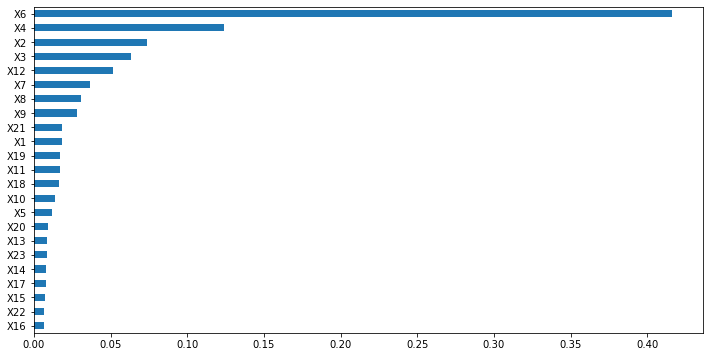

In [13]:
feature_importances = pd.Series(gbc.feature_importances_,index=X_train.columns)
display(feature_importances.sort_values(ascending=False).round(4))

fig,ax = plt.subplots(1,1,figsize=(12,6))
feature_importances.sort_values().plot.barh(ax=ax)

In [14]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(gbc,
                      threshold='mean',
                      prefit=True)

X_train.columns[sfm.get_support()]

Index(['X2', 'X3', 'X4', 'X6', 'X12'], dtype='object')

In [15]:
X_train_fs = sfm.transform(X_train)
X_test_fs = sfm.transform(X_test)

In [16]:
#params = {'learning_rate':[0.1,0.05,0.01],
#          'n_estimators':[10,50,100],
#          'max_depth':[1,2,5,7],
#          'min_samples_split': [2,3,4],
#          'min_samples_leaf':[1,3,5]}
#gscv = GridSearchCV(GradientBoostingClassifier(), params, n_jobs=-1)
#gscv.fit(X_train_fs,y_train)
#print(gscv.best_params_)

In [17]:
#best params output:{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}

In [18]:
start = timeit.default_timer()

gbc_fs = GradientBoostingClassifier(learning_rate=0.05,
                                 max_depth=5,
                                 min_samples_leaf=3,
                                 min_samples_split=2,
                                 n_estimators=100,
                                 )
gbc_fs.fit(X_train_fs,y_train)

stop = timeit.default_timer()

print(f'training accuracy: {gbc_fs.score(X_train_fs,y_train):0.4f}')
print(f'test accuracy: {gbc_fs.score(X_test_fs,y_test):0.4f}')
print(f'AUC: {roc_auc_score(y_test, gbc_fs.predict(X_test_fs)):0.4f}')
print('Time: ', round(stop - start, 4), 's')

training accuracy: 0.8723
test accuracy: 0.8172
AUC: 0.6442
Time:  3.3634 s
